In [3]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using StatsBase
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals_layers.jl")
include("NUTS_CS.jl");

In [235]:
#---------------------------
#Load Boston Housing Dataset
#---------------------------
data = load("boston.jld")["boston"]

# Generating test/training sets:
nrow, ncol = size(data)
nrow_test  = div(nrow, 3)
nrow_train = nrow - nrow_test

x = data[:,1:13]
y = data[:,14]

dx = fit(ZScoreTransform, x, dims=1)
StatsBase.transform!(dx, x)
dy = fit(ZScoreTransform, y; dims=1)
StatsBase.transform!(dy, y);

x_raw = x
x = transpose(x)

#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
#network = "classifier"
network = "interpolator"

#Data hyperparameters
n = nrow #Number of samples per mode (classifier)
d = ncol-1 #Input dimension

#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1

#NUTS
Δmax = 500;

In [236]:
#Bayesian Neural Net
function G(x, trace)
    activation = tanh
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function interpolator(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ######################################
    #New hyperparameter schedule - Jan 20#
    ######################################
    
    #Standard Deviations
    τ₁ ~ gamma(100,0.001) #Hidden weights and biases
    τ₂ ~ gamma(100*k[1],0.001) #Output weights and biases
    τᵧ ~ gamma(100, 0.02)
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    μ = [zeros(k[i]) for i=1:l+1]
    μb = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₁ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i]) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])    
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₁ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l]) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₂ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])  
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₂ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    #scores = Flux.tanh.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs = obs_master;

(best_trace,) = generate(interpolator, (x,), obs)
println(best_trace[:τ₁])
println(best_trace[:τ₂])
println(1 / best_trace[:τᵧ])

test_scores = interpolator(x)

0.10580630775164224
0.38952823513511087
0.5226613622469855


1×506 Array{Float64,2}:
 -7.42709  -7.15357  -7.42654  -7.4271  …  0.74463  0.623462  0.609449

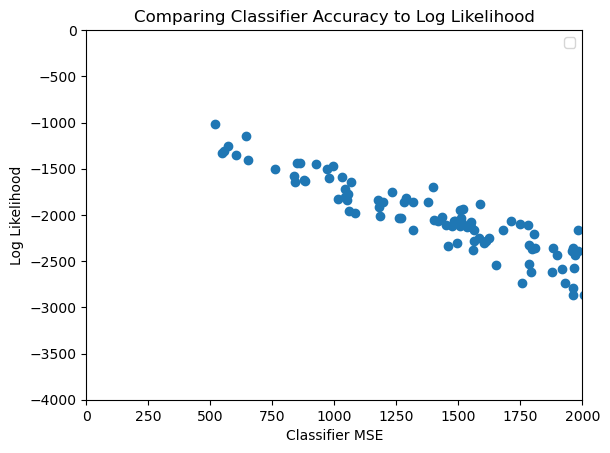

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f3f784873d0>

In [262]:
#----------------
#Test Likelihood
#----------------
scores = []
mses = []
ks = []
best_traces = []
(best_trace,) = generate(interpolator, (x,), obs)
best_score = get_score(best_trace)
best_pred_y = G(x, best_trace)
best_mse = mse_regression(best_pred_y, y)

function likelihood(best_trace, best_mse, best_score)
    obs = obs_master;
    (trace,) = generate(interpolator, (x,), obs)
    
    pred_y = (G(x, trace))
    mse = mse_regression(pred_y, y)
    score = get_score(trace)
    
    if mse < best_mse
        best_mse = mse
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
    end
    push!(scores,score)
    push!(mses,mse)
    return(best_trace, best_mse, best_score)
end;

for i=1:1000
    best_trace, best_mse, best_score = likelihood(best_trace, best_mse, best_score)
end

PyPlot.scatter(mses, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier MSE")
plt.ylabel("Log Likelihood")
plt.ylim(-4000,1)
plt.xlim(0,2000)
plt.legend()

4
[NUTS] start sampling for 4 samples with inital ϵ=1
....

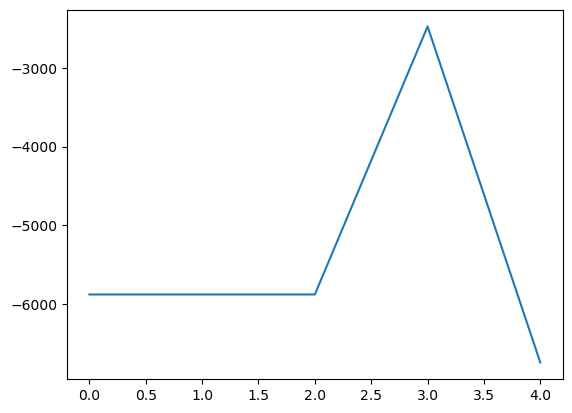


[NUTS] sampling complete with final apated ϵ = 0.01539664911465069


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3f78306c90>

In [267]:
include("NUTS_CS.jl");
#Random.seed!(105)
Δ_max = 10000
(trace,) = generate(interpolator,(x,),obs)
println(trace[:l])
param_selection = select()
for i=1:(trace[:l]+1) #Number of Layers
    push!(param_selection, (:μ,i))
    push!(param_selection, (:μb,i))
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end
traces = NUTS(trace, param_selection, 0.65, 4, 4, true)
plot([get_score(i) for i in traces])

In [268]:
###############
#NUTS SAMPLING#
###############

include("NUTS_CS.jl")
Δ_max = 5000
Random.seed!(4)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper1_acceptance = []
hyper2_acceptance = []

#HMC Hyperparameters
iters = 1
m = 4

function propose_hyperparameters(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    push!(hyper_selection, :τᵧ)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function hmc_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:μ,i))
        push!(param_selection, (:μb,i))
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            acc = 1
            return (new_trace, acc)
        else
            return (trace, acc)
        end
    end
    
    return (trace, acc)
end

function hmc_hyperparameters2(trace)
    
    l = trace[:l]
    hyper2_selection = select()
    for i=1:l+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    prev_score = get_score(trace)
    new_trace = NUTS(trace, hyper2_selection, 0.65, m, m, false)[m+1]
    new_score = get_score(new_trace)
    weight = new_score - prev_score
    #println(weight)
    
    #(new_trace, weight, retdiff) = regenerate(trace, hyper2_selection)
    
    #if log(rand()) < weight
    #    return (new_trace, 1)
    #else
    #    return (trace, 0)
    #end
    
    if prev_score != new_score
        return (new_trace, 1)
    else
        return (trace, 0)
    end
    
end

function node_parameter(trace)
    obs = obs_master
    
    init_trace = trace
    
    #################################################RJHMC#################################################
    #HMC Step 1
    trace_tilde = trace
    for i=1:iters
        (trace_tilde,) = propose_hyperparameters(trace_tilde)
        #(trace_tilde,) = hmc_hyperparameters2(trace_tilde)
        (trace_tilde,) = hmc_parameters(trace_tilde)
        #(trace_tilde, accepted) = hmc(trace_tilde,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    end
    #Reversible Jump Step
    (trace_prime, q_weight) = layer_change(trace_tilde)
    #HMC Step 2
    trace_star = trace_prime
    for i=1:iters
        #(trace_star, accepted) = hmc(trace_star,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        (trace_star,) = hmc_parameters(trace_star)
        #(trace_star,) = hmc_hyperparameters2(trace_star)
        (trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJHMC#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[:l]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

(trace,) = generate(interpolator, (x,), obs)
#trace = best_trace

for i=1:500
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted)  = propose_hyperparameters(trace)
    push!(hyper1_acceptance, accepted)
    #(trace, accepted)  = hmc_hyperparameters2(trace)
    #push!(hyper2_acceptance, accepted)
    (trace, accepted)  = hmc_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    push!(ks, trace[(:k,1)])
    println("$i : $(get_score(trace))")
    if i%20 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

********** Accepted: 4 **********
1 : -3242.3353057580207
2 : -4403.446538837079
********** Accepted: 3 **********
3 : -2046.3141426140628
4 : -3254.4415923184833
5 : -3401.700153804321
6 : -1679.4034726176858
7 : -2432.2960697469107
********** Accepted: 4 **********
8 : -1433.240260957816
9 : -3225.2003305590597
10 : -2752.041887073989
11 : -4617.899056124048
********** Accepted: 3 **********
12 : -4427.255547741605
********** Accepted: 2 **********
13 : -2221.0542080913724
********** Accepted: 1 **********
14 : -3089.6402881856366
********** Accepted: 2 **********
15 : -2437.781380277079
16 : -4714.6881150088275
********** Accepted: 3 **********
17 : -1882.9201186680948
18 : -4127.374399915199
19 : -4295.0142688998585
********** Accepted: 4 **********
20 : -3978.8642862421293
Epoch 20 A Acceptance Probability: 45.0 %
Epoch 20 W Acceptance Probability: 100.0 %
21 : -3369.5521553749354
22 : -2873.019733519842
23 : -4530.077068712614
********** Accepted: 3 **********
24 : -3849.92829349

183 : -4350.899517083621
184 : -1554.345994185866
185 : -5642.1938440584945
********** Accepted: 2 **********
186 : -1953.2258873188057
187 : -5254.037220807647
********** Accepted: 3 **********
188 : -3890.252380729125
********** Accepted: 4 **********
189 : -3375.109543423857
190 : -4794.428407724651
191 : -2469.07332228136
192 : -3008.913146933352
********** Accepted: 3 **********
193 : -2916.5223659192006
********** Accepted: 2 **********
194 : -2965.2694883175523
********** Accepted: 1 **********
195 : -3806.974321966812
196 : -1934.117093637346
197 : -3800.479456735069
198 : -5202.755225006812
********** Accepted: 2 **********
199 : -3818.822720759179
********** Accepted: 3 **********
200 : -4430.328192062526
Epoch 200 A Acceptance Probability: 46.0 %
Epoch 200 W Acceptance Probability: 100.0 %
********** Accepted: 4 **********
201 : -4334.503322958584
********** Accepted: 3 **********
202 : -1709.9954120090238
203 : -4323.193909500433
204 : -3250.9450781719524
205 : -3604.697715

InterruptException: InterruptException:

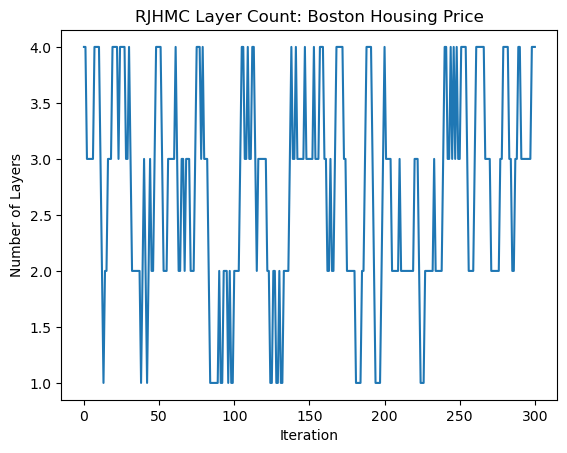

In [269]:
#Layers Plot
layers = [trace[:l] for trace in traces]
plot(layers)
plt.title("RJHMC Layer Count: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Number of Layers");

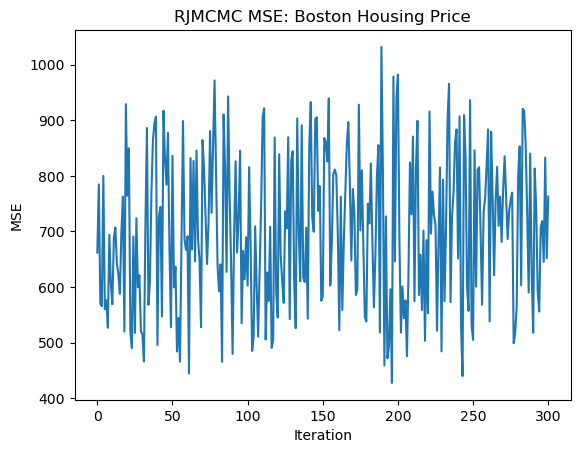

In [270]:
#Plot MSE Scores by Trace
mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = Flux.σ.(G(x,trace))
    mse = mse_regression(pred_y, y)

    push!(mses,mse)
end

plot(mses)
plt.title("RJMCMC MSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("MSE");

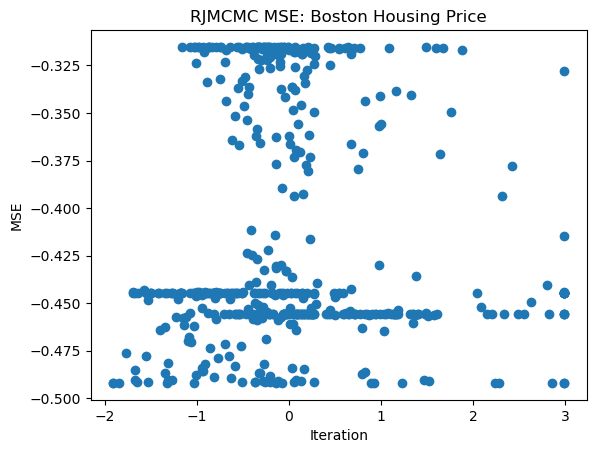

PyObject <matplotlib.collections.PathCollection object at 0x7f3f7a549710>

In [145]:
#Plot MSE Scores by Trace
mses = []
pred_y = y
for i=1:length(traces)
    trace = traces[i]
    pred_y = (G(x,trace))
    mse = mse_regression(pred_y, y)
    #println(pred_y[10:15])

    push!(mses,mse)
end

#plot(mses)
plt.title("RJMCMC MSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("MSE");
scatter(y,pred_y)

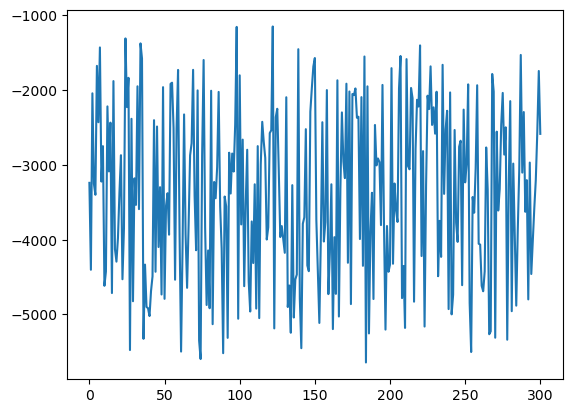

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3f78158a10>

In [271]:
scores = [get_score(trace) for trace in traces]
plot(scores)

In [ ]:
#--------------------
#RJMCMC - using HMC
#--------------------
traces = []
scores = []
acc = []
acc_l = []
acc_w = []
l_results = []
epss = []
l = 10
ϵ = 0.001

function within_move(trace, iters, obs, prev_trace)
    selection = select_selection(trace)
    score1 = get_score(prev_trace)
    (new_trace, hmc_score) = hmc_mod(trace, selection, L=l, eps=ϵ, check=false, observations=obs)
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    acc_score = score2 - score1
    #println("Calc score: $acc_score")
    #println("hmc_score: $hmc_score")
    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = prev_trace
        accepted = 0.0
        #println("Not Accepted")
    end
    #push!(traces, trace)
    push!(acc, accepted)
    push!(acc_w, accepted)
    #accepted && println("Within accepted")
    return trace
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC")
    println("Starting ks: $ks")
    println("--------------------------------")

    for i=1:iters
        l = trace[:l]
        obs = obs_master;
        if i%50 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            #println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        prev_trace = trace
        trace, obs = select_hyperparameters(prev_trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 1.0
            (trace) = layer_move(trace, 3, obs, prev_trace)
        else
            (trace) = within_move(trace, 10, obs, prev_trace)
        end
        push!(traces, trace)
        push!(scores, get_score(trace))
        push!(l_results, trace[:l])
    end
    println("Finished")
end
 
runs = 2000

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs_master[:l] = 4
obs = obs_master;
(starting_trace,) = generate(interpolator, (x,), obs)
#starting_trace = best_trace

include("NUTS.jl");
rjmcmc(starting_trace,runs);